# Cis Effects 8q

## Setup

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cptac
from scipy import stats
from cnvutils import *
import statsmodels.stats.multitest
import cptac.utils

## Stuff to fill out

In [18]:
# Enter the Chromosome and arm you are looking at. 
CHROMOSOME = '8'
ARM = 'q'
EVENT_START = 52110839
EVENT_END = 145052465

In [19]:
cancer_types = {
    # Put here all the types of cancer that you want to look at. 
    'luad': cptac.Luad(),
    'hnscc': cptac.Hnscc(),
    'ovarian': cptac.Ovarian(),
    'colon': cptac.Colon(),
    'brca': cptac.Brca(),
    'lscc': cptac.Lscc()
}

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-19-b4fc22a72b62>, line 4)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-19-b4fc22a72b62>, line 8)


## Load all the data

In [21]:
# proteomics = dict()
# cnv = dict()
# transcriptomics = dict()
# for cancer_type in cancer_types:
#     proteomics[cancer_type] = cancer_types[cancer_type].get_proteomics()
#     cnv[cancer_type] = cancer_types[cancer_type].get_CNV()
#     transcriptomics[cancer_type] = cancer_types[cancer_type].get_transcriptomics()

In [22]:
locations = get_gene_locations()

In [23]:
# Get just the genes that are in our event
subset_event = locations[(locations.chromosome == CHROMOSOME) & (locations.arm == ARM) & (locations.start_bp >= EVENT_START) & (locations.end_bp <= EVENT_END)]
genes = set(subset_event.index.get_level_values('Name'))

## Run Pearson Tests

In [24]:
def run_pearsons(protein, cnv_df, omics):
    try:
        if protein in cnv_df.columns.get_level_values('Name'):
            cnv_data = cnv_df.loc[:,cnv_df.columns.get_level_values('Name')==protein]
            cnv_column_name = cnv_data.columns.tolist()[0]
        else:
            return (np.nan, np.nan)
        omics_data = omics[protein]
        if isinstance(omics_data, pd.DataFrame):
            omics_data = omics.iloc[:,0]
        omics_data.name = 'omics'
        df = pd.concat([cnv_data, omics_data], axis=1)
        df.dropna(inplace=True)
        if len(df) < 3:
            return (np.nan,np.nan)
        return stats.pearsonr(df[cnv_column_name], df['omics'])
    except Exception as e:
        print(e)

### Proteomics

In [25]:
proteomics_results = None
for cancer_type in proteomics.keys():
    try:
        # We will use the index from the proteomics table. 
        proteomics_table = proteomics[cancer_type].copy()
        proteomics_table = proteomics_table.loc[:, proteomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(proteomics_table.columns, pd.MultiIndex):
            proteomics_table = proteomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = proteomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], proteomics_table)
            pvalues.append(p)
            rvalues.append(r)
        # Correct for multiple tests
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_proteomics': pval_corrected, f'{cancer_type}_rvalue_proteomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if proteomics_results is not None:
            proteomics_results = proteomics_results.join(temp, how='outer')
        else:
            proteomics_results = temp
    except Exception as e:
        print(e)

In [26]:
proteomics_results

,luad_pvalue_proteomics,luad_rvalue_proteomics,hnscc_pvalue_proteomics,hnscc_rvalue_proteomics,ovarian_pvalue_proteomics,ovarian_rvalue_proteomics,colon_pvalue_proteomics,colon_rvalue_proteomics,brca_pvalue_proteomics,brca_rvalue_proteomics,lscc_pvalue_proteomics,lscc_rvalue_proteomics
Name,,,,,,,,,,,,
ADCK5,1.071355e-06,0.529184,4.025665e-02,0.255199,NaN,NaN,5.200657e-01,0.137726,1.203762e-03,0.343326,1.493486e-02,0.278639
ADCY8,2.825241e-01,-0.199202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADHFE1,5.591530e-01,-0.094753,8.827123e-01,-0.024365,1.310936e-01,0.208438,NaN,NaN,8.381515e-01,-0.025818,7.173051e-01,0.062784
AGO2,1.464466e-09,0.561370,6.060852e-09,0.561954,7.274694e-06,0.506962,2.228620e-08,0.567648,3.099972e-08,0.496262,2.811529e-10,0.596681
ANGPT1,1.107765e-02,-0.272637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.980819e-01,0.020585
...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF251,5.731755e-01,0.075016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.309866e-01,0.037579
ZNF34,NaN,NaN,NaN,NaN,7.667676e-01,-0.041977,NaN,NaN,NaN,NaN,NaN,NaN
ZNF623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.746068e-03,0.329596,2.394204e-01,0.155132


### Transcriptomics

In [27]:
transcriptomics_results = None
for cancer_type in transcriptomics.keys():
    try:
        # We will use the index from the proteomics table. 
        transcriptomics_table = transcriptomics[cancer_type].copy()
        transcriptomics_table = transcriptomics_table.loc[:, transcriptomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(transcriptomics_table.columns, pd.MultiIndex):
            transcriptomics_table = transcriptomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = transcriptomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], transcriptomics_table)
            pvalues.append(p)
            rvalues.append(r)
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_transcriptomics': pval_corrected, f'{cancer_type}_rvalue_transcriptomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if transcriptomics_results is not None:
            transcriptomics_results = transcriptomics_results.join(temp, how='outer')
        else:
            transcriptomics_results = temp
    except Exception as e:
        print(e)

C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\

C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\

In [28]:
transcriptomics_results

,luad_pvalue_transcriptomics,luad_rvalue_transcriptomics,hnscc_pvalue_transcriptomics,hnscc_rvalue_transcriptomics,ovarian_pvalue_transcriptomics,ovarian_rvalue_transcriptomics,colon_pvalue_transcriptomics,colon_rvalue_transcriptomics,brca_pvalue_transcriptomics,brca_rvalue_transcriptomics,lscc_pvalue_transcriptomics,lscc_rvalue_transcriptomics
Name,,,,,,,,,,,,
AARD,6.356175e-01,-0.055060,7.882077e-01,-0.033735,4.117559e-03,0.302940,NaN,NaN,7.860418e-03,0.260587,9.793174e-01,0.003161
ABRA,8.793561e-04,0.327661,9.080882e-01,0.014087,1.942591e-01,-0.147640,NaN,NaN,7.895485e-01,-0.086423,1.070717e-01,-0.271560
ADCK5,9.719253e-23,0.782195,9.433319e-13,0.638019,NaN,NaN,1.963035e-11,0.610827,1.582929e-08,0.756367,7.660768e-07,0.470326
ADCY8,2.380193e-01,0.130965,9.080882e-01,0.013893,7.007415e-01,0.049351,NaN,NaN,3.813367e-01,0.138662,5.617166e-01,0.071655
ADGRB1,4.321550e-03,0.283806,1.559108e-01,0.157131,NaN,NaN,NaN,NaN,NaN,NaN,5.988875e-01,0.061999
...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF696,3.439237e-22,0.775788,2.253568e-12,0.629734,6.514544e-11,0.615532,3.594275e-15,0.692380,2.627149e-15,0.667046,8.249372e-18,0.728937
ZNF7,3.204770e-32,0.867147,9.333276e-22,0.785909,2.889885e-17,0.746397,5.466603e-23,0.801751,5.788307e-18,0.715206,2.597047e-09,0.549522
ZNF704,5.536548e-02,0.196740,3.293007e-01,0.111061,5.984369e-07,0.492041,9.895385e-08,0.502647,1.622224e-02,0.235563,8.336708e-05,0.386096


In [29]:
# stats.stdev(list(proteomics_results['brca_rvalue_proteomics']))

In [30]:
# sns.distplot(proteomics_results['lscc_rvalue_proteomics'])

## Create Graphs

In [31]:
# Join the graphs
all_results = transcriptomics_results.join(proteomics_results)

In [34]:
all_results.to_csv('pearson_cis_effect_results_8q.tsv', sep='\t')

In [32]:
all_results

,luad_pvalue_transcriptomics,luad_rvalue_transcriptomics,hnscc_pvalue_transcriptomics,hnscc_rvalue_transcriptomics,ovarian_pvalue_transcriptomics,ovarian_rvalue_transcriptomics,colon_pvalue_transcriptomics,colon_rvalue_transcriptomics,brca_pvalue_transcriptomics,brca_rvalue_transcriptomics,...,hnscc_pvalue_proteomics,hnscc_rvalue_proteomics,ovarian_pvalue_proteomics,ovarian_rvalue_proteomics,colon_pvalue_proteomics,colon_rvalue_proteomics,brca_pvalue_proteomics,brca_rvalue_proteomics,lscc_pvalue_proteomics,lscc_rvalue_proteomics
Name,,,,,,,,,,,,,,,,,,,,,
AARD,6.356175e-01,-0.055060,7.882077e-01,-0.033735,4.117559e-03,0.302940,NaN,NaN,7.860418e-03,0.260587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABRA,8.793561e-04,0.327661,9.080882e-01,0.014087,1.942591e-01,-0.147640,NaN,NaN,7.895485e-01,-0.086423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADCK5,9.719253e-23,0.782195,9.433319e-13,0.638019,NaN,NaN,1.963035e-11,0.610827,1.582929e-08,0.756367,...,0.040257,0.255199,NaN,NaN,0.520066,0.137726,1.203762e-03,0.343326,0.014935,0.278639
ADCY8,2.380193e-01,0.130965,9.080882e-01,0.013893,7.007415e-01,0.049351,NaN,NaN,3.813367e-01,0.138662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADGRB1,4.321550e-03,0.283806,1.559108e-01,0.157131,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF696,3.439237e-22,0.775788,2.253568e-12,0.629734,6.514544e-11,0.615532,3.594275e-15,0.692380,2.627149e-15,0.667046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZNF7,3.204770e-32,0.867147,9.333276e-22,0.785909,2.889885e-17,0.746397,5.466603e-23,0.801751,5.788307e-18,0.715206,...,0.030200,0.419626,NaN,NaN,NaN,NaN,NaN,NaN,0.024719,0.258191
ZNF704,5.536548e-02,0.196740,3.293007e-01,0.111061,5.984369e-07,0.492041,9.895385e-08,0.502647,1.622224e-02,0.235563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


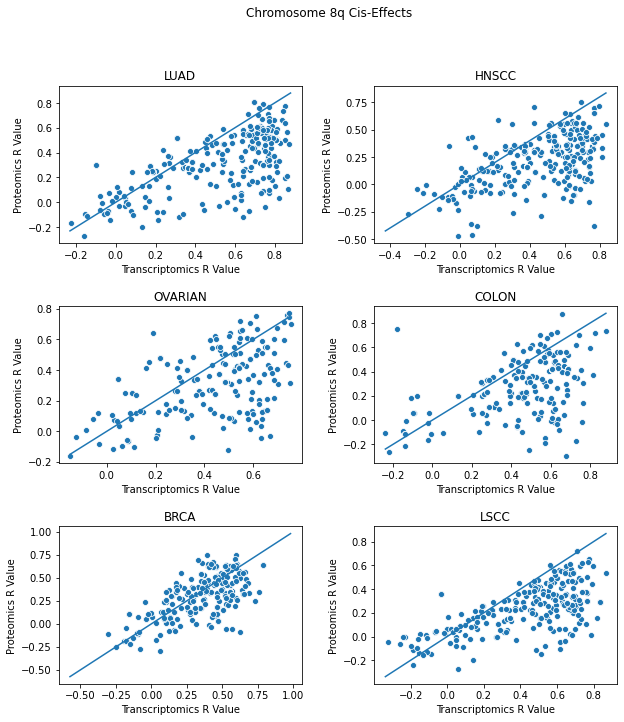

In [33]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(10,11))
fig.suptitle("Chromosome 8q Cis-Effects")
count = 0
for cancer_type in proteomics.keys():
    sns.scatterplot(x=f'{cancer_type}_rvalue_transcriptomics', y=f'{cancer_type}_rvalue_proteomics', data=all_results, ax=axs[count//2][count%2])
    axs[count//2][count%2].set_title(cancer_type.upper())
    axs[count//2][count%2].set_xlabel("Transcriptomics R Value")
    axs[count//2][count%2].set_ylabel("Proteomics R Value")
    min_val = np.min(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    max_val = np.max(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    axs[count//2][count%2].plot([min_val,max_val], [min_val,max_val])
    count += 1
plt.subplots_adjust(hspace=0.4, wspace=0.3)